In [22]:
import zipfile
zf = zipfile.ZipFile('./celeba.zip')
zf.extractall('./')
zf.close()

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 202608
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 202608
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 202608
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 202608
Use %enable_full_walk to se

In [161]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
import glob

filelist = glob.glob('./celeba/celeba/img_align_celeba/*.jpg')
print(len(filelist))

202599


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 202599
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 202608
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 202608
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 202608
Use %enable_full_walk to se

## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [68]:
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.0 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 7.2 MB/s 
     |████████████████████████████████| 97 kB 3.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=3299 sha256=c798af00736ad3dc02ae986aa0657edd5fa0b02853db63c284bc6f2d3aacc8a6
  Stored in directory: /home/jupyter/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8604 sha256=4d8f20b620378722edf4fe2cad7966177483c012cde5497a7c67194897da380a
  Stored in directory: /home/jupyter/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [162]:
import numpy as np
import torchvision

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split

from tqdm.notebook import tqdm
from IPython.display import clear_output
import wandb

import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [163]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [164]:
def target_transform(label):
    indices = [4, 8, 9, 11, 12, 13, 18, 20, 22, 24]
    return label[indices].float()

celeba = torchvision.datasets.CelebA('celeba', target_type='attr', \
                                     transform=transforms, target_transform=target_transform, download=False)
celeba_dataloader = torch.utils.data.DataLoader(celeba, 1, shuffle=True)
index2attr = {i:j for i, j in enumerate(celeba.attr_names)}
indices = [4, 8, 9, 11, 12, 13, 18, 20, 22, 24]
attr_names = [index2attr[i] for i in indices]
index2attr = {i:j for i, j in enumerate(attr_names)}

In [165]:
index2attr

{0: 'Bald',
 1: 'Black_Hair',
 2: 'Blond_Hair',
 3: 'Brown_Hair',
 4: 'Bushy_Eyebrows',
 5: 'Chubby',
 6: 'Heavy_Makeup',
 7: 'Male',
 8: 'Mustache',
 9: 'No_Beard'}

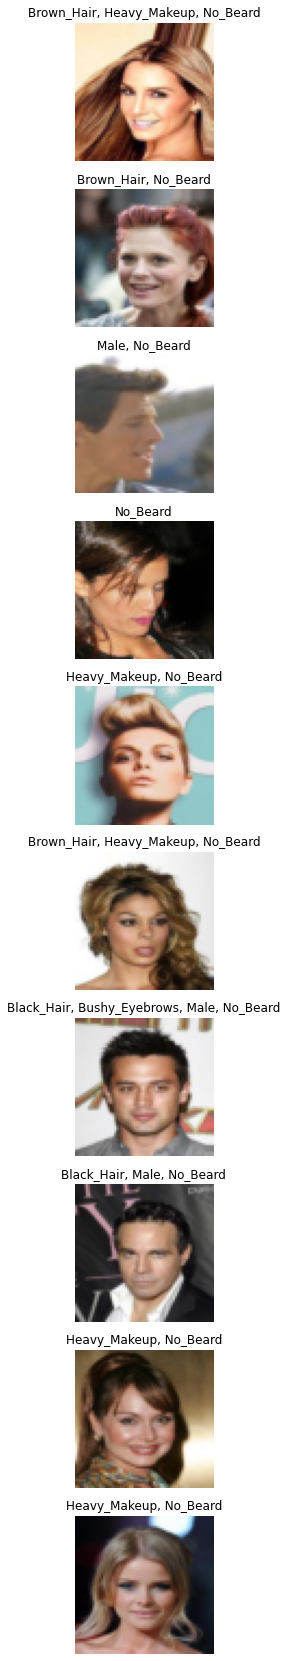

In [115]:
plt.figure(figsize=(30, 30))
for index, (image, attr) in enumerate(celeba):
    if index >= 10: break
    plt.subplot(10, 1, index+1)
    plt.imshow((image.squeeze().permute(1, 2, 0) + 1) / 2)
    plt.title(', '.join([index2attr[att_i] for att_i, att_val in enumerate(attr.view(-1)) if att_val == 1]))
    plt.axis('off')

plt.show()

В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

In [140]:
train_dataset, test_dataset = random_split(celeba, [len(celeba) * 9 // 10, len(celeba) // 10])

In [117]:
init_config = {
    'c_dim': len(indices),
    'lam_cls': 1,
    'lam_rec': 1,
    'lam_gp': 10
}

train_config = {
    'epochs': 15,
    'batch_size': 16,
    'g_lr': 1e-4,
    'd_lr': 1e-4,
    'n_critic': 3,
    'beta_1': 0.5,
    'beta_2': 0.999,
    'decay_start': 5
}

In [158]:
from augmented_dataset import AugmentedDataset
transform = torchvision.transforms.RandomHorizontalFlip(0.5)
aug_dataset = AugmentedDataset(train_dataset, transform)

In [160]:
from model import StarGAN
# from utils import permute_labels

model = StarGAN(aug_dataset, test_dataset, config)

SyntaxError: invalid syntax (model.py, line 59)

In [ ]:
model.train()
for image, label in tqdm(celeba_dataloader, leave=False, desc=f"trainloop: {epoch}"):
    # YOUR CODE

model.eval()
for ind, (image, label) in enumerate(celeba_val_dataloader): # batch = 1
    if ind >= 10: break

    # пример сравнения качества на глаз:
    new_label = permute_labels(label)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow((image[0].permute(1, 2, 0) + 1) / 2)
    plt.subplot(1, 2, 2)
    fake_image = model.generate(image.to(device), new_label.to(device)).detach().cpu()[0]
    plt.imshow((fake_image.permute(1, 2, 0) + 1) / 2)
    plt.show()


## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежить готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета